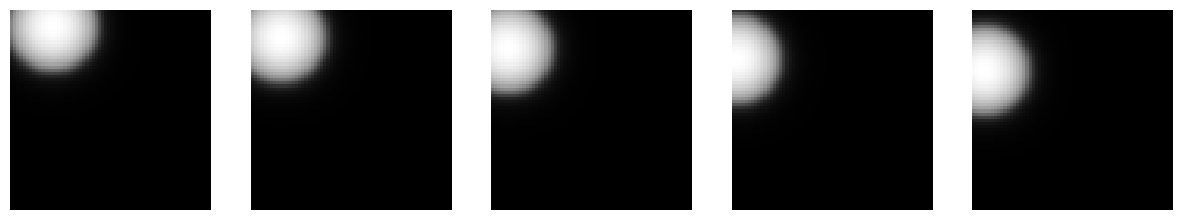

torch.Size([64, 1, 64, 64])


In [9]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')], key=lambda x: int(x.split('_')[1].split('.')[0]))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_name).convert('L')  # Convert image to grayscale
        if self.transform:
            image = self.transform(image)
        return image

# Define the directory where images are stored
image_dir = 'images'

# Define transformations (if any)
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the dataset
dataset = CustomDataset(image_dir=image_dir, transform=transform)

# Calculate lengths for train, val, test datasets
total_len = len(dataset)
train_len = int(0.6 * total_len)
val_len = int(0.2 * total_len)
test_len = total_len - train_len - val_len

# Create subsets manually by indices
train_indices = list(range(0, train_len))
val_indices = list(range(train_len, train_len + val_len))
test_indices = list(range(train_len + val_len, total_len))

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Function to display images
def show_images(images, nrow=1, ncol=5):
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 3))
    for i in range(ncol):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

# Display the first five images in the dataset
if __name__ == '__main__':
    # Display the first five images
    first_five_images = [dataset[i] for i in range(5)]
    show_images(first_five_images)
    
    # Example usage of data loaders
    for images in train_loader:
        print(images.size())  # Example output: torch.Size([64, 1, H, W])
        break

Using device: cuda
Epoch [1/100], Train Loss: 0.2308, Val Loss: 0.2272
Epoch [2/100], Train Loss: 0.2096, Val Loss: 0.1733
Epoch [3/100], Train Loss: 0.1362, Val Loss: 0.1018
Epoch [4/100], Train Loss: 0.0860, Val Loss: 0.0778
Epoch [5/100], Train Loss: 0.0762, Val Loss: 0.0745
Epoch [6/100], Train Loss: 0.0736, Val Loss: 0.0725
Epoch [7/100], Train Loss: 0.0719, Val Loss: 0.0711
Epoch [8/100], Train Loss: 0.0708, Val Loss: 0.0701
Epoch [9/100], Train Loss: 0.0698, Val Loss: 0.0693
Epoch [10/100], Train Loss: 0.0692, Val Loss: 0.0688
Epoch [11/100], Train Loss: 0.0687, Val Loss: 0.0683
Epoch [12/100], Train Loss: 0.0683, Val Loss: 0.0679
Epoch [13/100], Train Loss: 0.0678, Val Loss: 0.0674
Epoch [14/100], Train Loss: 0.0672, Val Loss: 0.0667
Epoch [15/100], Train Loss: 0.0663, Val Loss: 0.0653
Epoch [16/100], Train Loss: 0.0639, Val Loss: 0.0610
Epoch [17/100], Train Loss: 0.0552, Val Loss: 0.0457
Epoch [18/100], Train Loss: 0.0381, Val Loss: 0.0302
Epoch [19/100], Train Loss: 0.0249, 

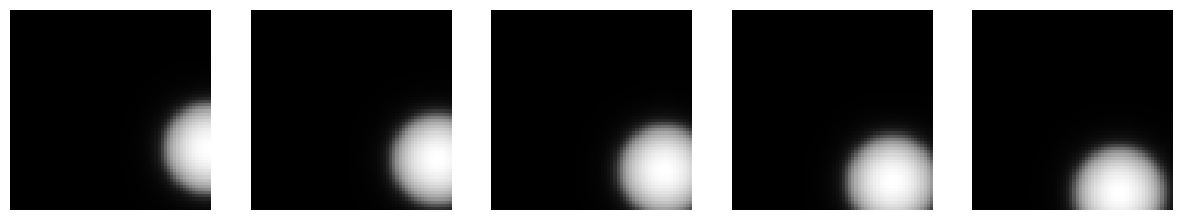

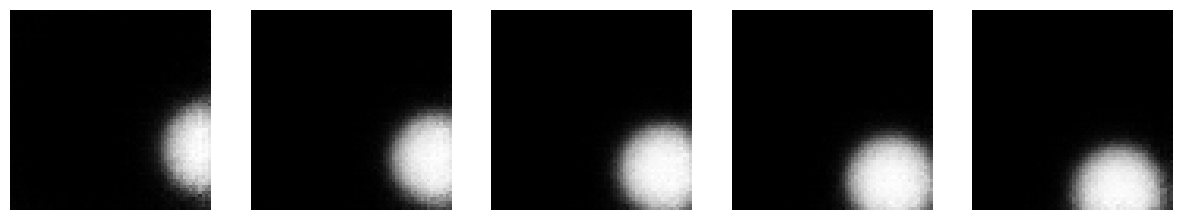

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import os

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # (B, 1, 64, 64) -> (B, 16, 32, 32)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (B, 16, 32, 32) -> (B, 32, 16, 16)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (B, 32, 16, 16) -> (B, 64, 8, 8)
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 512)  # (B, 64*8*8) -> (B, 512)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(512, 64 * 8 * 8),  # (B, 512) -> (B, 64*8*8)
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 64, 8, 8) -> (B, 32, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 32, 16, 16) -> (B, 16, 32, 32)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 16, 32, 32) -> (B, 1, 64, 64)
            nn.Sigmoid()  # Ensure the output values are between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Initialize the autoencoder, loss function and optimizer
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)

# Function to save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Training function
def train_autoencoder(model, train_loader, val_loader, criterion, optimizer, epochs):
    model.train()
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images in val_loader:
                images = images.to(device)
                outputs = model(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Save the best model based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_model(model.encoder, 'best_encoder_1.pth')
            save_model(model.decoder, 'best_decoder_1.pth')

    # Print the best validation loss
    print(f'Best Validation Loss: {best_val_loss:.4f}')
    
    return model

# Evaluation function
def evaluate_autoencoder(model, dataloader):
    model.eval()
    original_images = []
    reconstructed_images = []
    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            outputs = model(images)
            original_images.extend(images.cpu())
            reconstructed_images.extend(outputs.cpu())
            break  # Remove this line if you want to evaluate the whole dataset
    return original_images, reconstructed_images

# Assume train_loader, val_loader, and test_loader are defined and loaded elsewhere

# Train the autoencoder
autoencoder = train_autoencoder(autoencoder, train_loader, val_loader, criterion, optimizer, epochs=100)

# Evaluate the autoencoder
original_images, reconstructed_images = evaluate_autoencoder(autoencoder, test_loader)

# Display original and reconstructed images
show_images([original_images[i] for i in range(5)], nrow=1, ncol=5)
show_images([reconstructed_images[i] for i in range(5)], nrow=1, ncol=5)


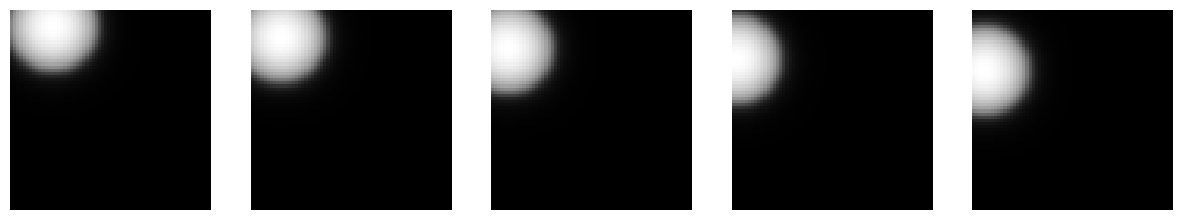

torch.Size([64, 1, 64, 64])


In [11]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')], key=lambda x: int(x.split('_')[1].split('.')[0]))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_name).convert('L')  # Convert image to grayscale
        if self.transform:
            image = self.transform(image)
        return image

# Define the directory where images are stored
image_dir = 'images'

# Define transformations (if any)
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the dataset
dataset = CustomDataset(image_dir=image_dir, transform=transform)

# Calculate lengths for train, val, test datasets
total_len = len(dataset)
train_len = int(0.6 * total_len)
val_len = int(0.2 * total_len)
test_len = total_len - train_len - val_len

# Create subsets manually by indices
train_indices = list(range(0, train_len))
val_indices = list(range(train_len, train_len + val_len))
test_indices = list(range(train_len + val_len, total_len))

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Function to display images
def show_images(images, nrow=1, ncol=5):
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 3))
    for i in range(ncol):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

# Display the first five images in the dataset
if __name__ == '__main__':
    # Display the first five images
    first_five_images = [dataset[i] for i in range(5)]
    show_images(first_five_images)
    
    # Example usage of data loaders
    for images in train_loader:
        print(images.size())  # Example output: torch.Size([64, 1, H, W])
        break

In [12]:
import torch
import torch.nn as nn

class SimpleLinearNetwork(nn.Module):
    def __init__(self):
        super(SimpleLinearNetwork, self).__init__()
        self.flatten = nn.Flatten()  # 将输入展平
        self.linear = nn.Linear(64 * 64, 256)  # 一个线性层

    def forward(self, x):
        x = self.flatten(x)  # 展平输入
        x = self.linear(x)  # 线性层变换
        return x

# 示例张量 (B, 1, 64, 64)
input_tensor = torch.randn(8, 1, 64, 64)  # 这里 B = 8 作为示例

# 创建网络实例
model = SimpleLinearNetwork()

# 前向传播
output_tensor = model(input_tensor)
print(output_tensor.shape)  # 期望输出 (B, 256)，这里 B = 8

torch.Size([8, 256])


In [13]:
import torch
import torch.nn as nn

class Time2Vec(nn.Module):
    def __init__(self, seq_len):
        super(Time2Vec, self).__init__()
        self.seq_len = seq_len
        self.weights_linear = nn.Parameter(torch.Tensor(seq_len // 2))
        self.bias_linear = nn.Parameter(torch.Tensor(seq_len // 2))
        self.weights_periodic = nn.Parameter(torch.Tensor(seq_len // 2))
        self.bias_periodic = nn.Parameter(torch.Tensor(seq_len // 2))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.weights_linear)
        nn.init.uniform_(self.bias_linear)
        nn.init.uniform_(self.weights_periodic)
        nn.init.uniform_(self.bias_periodic)

    def forward(self, x):
        x_mean = torch.mean(x, dim=-1, keepdim=True)  # (B, 256) -> (B, 1)
        
        # 线性时间嵌入
        time_linear = self.weights_linear * x_mean + self.bias_linear  # (B, 1) -> (B, 128)
        
        # 周期性时间嵌入
        time_periodic = torch.sin(self.weights_periodic * x_mean + self.bias_periodic)  # (B, 1) -> (B, 128)
        
        # 拼接线性和周期性时间嵌入
        time_embedding = torch.cat([time_linear, time_periodic], dim=-1)  # (B, 128) and (B, 128) -> (B, 256)
        
        # 残差连接，将输入x与时间嵌入拼接
        residual_connection = torch.cat([x, time_embedding], dim=-1)  # (B, 256) and (B, 256) -> (B, 512)
        
        return residual_connection

# 示例用法
input_tensor = torch.randn(32, 256)  # (B, 256)
model = Time2Vec(seq_len=256)
output_tensor = model(input_tensor)  # (B, 512)

print(output_tensor.shape)  # 应输出: torch.Size([32, 512])


torch.Size([32, 512])


In [14]:
import torch
import torch.nn as nn

class SingleAttentionHead(nn.Module):
    def __init__(self, input_dim, d_k, d_v):
        super(SingleAttentionHead, self).__init__()
        self.d_k = d_k
        self.d_v = d_v

        self.W_Q = nn.Linear(input_dim, d_k)  # (input_dim, d_k)
        self.W_K = nn.Linear(input_dim, d_k)  # (input_dim, d_k)
        self.W_V = nn.Linear(input_dim, d_v)  # (input_dim, d_v)
        self.softmax = nn.Softmax(dim=-1)  # 使用 nn.Softmax

    def forward(self, X):
        # X: (B, input_dim)
        Q = self.W_Q(X)  # (B, d_k)
        K = self.W_K(X)  # (B, d_k)
        V = self.W_V(X)  # (B, d_v)

        # scores: (B, B)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))  
        
        # attention_weights: (B, B)
        attention_weights = self.softmax(scores)
        
        # attention_output: (B, d_v)
        attention_output = torch.matmul(attention_weights, V)  

        return attention_output

# 示例使用
B = 32  # 批次大小
input_dim = 512  # 输入维度
d_k = 64
d_v = 128

# 随机生成输入张量
X = torch.randn(B, input_dim)

# 创建注意力头实例
attention_head = SingleAttentionHead(input_dim, d_k, d_v)

# 前向传播
output = attention_head(X)

print("Attention Output Shape:", output.shape)  # 输出应为 (B, d_v)


Attention Output Shape: torch.Size([32, 128])


In [15]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, num_heads, d_k, d_v):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_k = d_k
        self.d_v = d_v

        # 创建多个注意力头，每个注意力头都是一个SingleAttentionHead实例
        self.attention_heads = nn.ModuleList([SingleAttentionHead(input_dim, d_k, d_v) for _ in range(num_heads)])
        self.W_O = nn.Linear(num_heads * d_v, input_dim)  # (num_heads * d_v, input_dim)


    def forward(self, X):
        # X: (B, input_dim)
        
        # 获取所有头的注意力输出，列表中的每个元素形状为 (B, d_v)
        attention_outputs = [head(X) for head in self.attention_heads]
        
        # 拼接所有头的输出，结果形状为 (B, num_heads * d_v)
        concat_output = torch.cat(attention_outputs, dim=-1)
        
        # 通过线性变换，最终输出形状为 (B, input_dim)
        output = self.W_O(concat_output)
        
        return output

# 示例使用
B = 32  # 批次大小
input_dim = 512  # 输入维度
num_heads = 8  # 头的数量
d_k = 64
d_v = 128

# 随机生成输入张量
X = torch.randn(B, input_dim)

# 创建多头注意力实例
multi_head_attention = MultiHeadAttention(input_dim, num_heads, d_k, d_v)

# 前向传播
output = multi_head_attention(X)

print("Multi-Head Attention Output Shape:", output.shape)  # 输出应为 (B, input_dim)


Multi-Head Attention Output Shape: torch.Size([32, 512])


In [16]:
import torch
import torch.nn as nn

class ProcessingModule(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=2048, dropout_rate=0.1):
        super(ProcessingModule, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.norm1 = nn.LayerNorm(input_dim)
        self.feed_forward = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
        self.norm2 = nn.LayerNorm(input_dim)

    def forward(self, x):
        # Residual connection around dropout and normalization
        residual = x
        x = self.dropout(x)
        x = self.norm1(x + residual)
        
        # Feed-forward network
        x = self.feed_forward(x)
        
        # Add residual connection and apply final normalization
        x = self.norm2(x + residual)
        
        return x

# Example usage
batch_size = 32  # Example batch size
input_tensor = torch.randn((batch_size, 512))  # replace batch_size with your batch size
model = ProcessingModule()
output = model(input_tensor)

print("Output shape:", output.shape)  # Print output shape


Output shape: torch.Size([32, 512])


In [20]:
class CombinedNetwork(nn.Module):
    def __init__(self, seq_len, input_dim, num_heads, d_k, d_v):
        super(CombinedNetwork, self).__init__()
        
        self.encoder = nn.Sequential(
            SimpleLinearNetwork(),
            Time2Vec(seq_len),
            MultiHeadAttention(input_dim, num_heads, d_k, d_v),
            ProcessingModule(input_dim=input_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(512, 64 * 8 * 8),  # (B, 512) -> (B, 64*8*8)
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 64, 8, 8) -> (B, 32, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 32, 16, 16) -> (B, 16, 32, 32)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 16, 32, 32) -> (B, 1, 64, 64)
            nn.Sigmoid()  # Ensure the output values are between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 示例使用
seq_len = 256
input_dim = 512
num_heads = 8
d_k = 64
d_v = 128

model = CombinedNetwork(seq_len, input_dim, num_heads, d_k, d_v)
sample_input = torch.randn((32, 1, 64, 64))  # 假设输入是32个64x64的单通道图像
output = model(sample_input)
print(output.shape)  # 输出形状

torch.Size([32, 1, 64, 64])


Using device: cuda
Epoch [1/1000], Train Loss: 0.1880, Val Loss: 0.1774
Epoch [2/1000], Train Loss: 0.1628, Val Loss: 0.1452
Epoch [3/1000], Train Loss: 0.1299, Val Loss: 0.1133
Epoch [4/1000], Train Loss: 0.0996, Val Loss: 0.0871
Epoch [5/1000], Train Loss: 0.0811, Val Loss: 0.0763
Epoch [6/1000], Train Loss: 0.0735, Val Loss: 0.0708
Epoch [7/1000], Train Loss: 0.0685, Val Loss: 0.0666
Epoch [8/1000], Train Loss: 0.0646, Val Loss: 0.0636
Epoch [9/1000], Train Loss: 0.0592, Val Loss: 0.0549
Epoch [10/1000], Train Loss: 0.0469, Val Loss: 0.0399
Epoch [11/1000], Train Loss: 0.0335, Val Loss: 0.0286
Epoch [12/1000], Train Loss: 0.0255, Val Loss: 0.0231
Epoch [13/1000], Train Loss: 0.0215, Val Loss: 0.0209
Epoch [14/1000], Train Loss: 0.0186, Val Loss: 0.0186
Epoch [15/1000], Train Loss: 0.0162, Val Loss: 0.0165
Epoch [16/1000], Train Loss: 0.0141, Val Loss: 0.0144
Epoch [17/1000], Train Loss: 0.0117, Val Loss: 0.0120
Epoch [18/1000], Train Loss: 0.0092, Val Loss: 0.0100
Epoch [19/1000], T

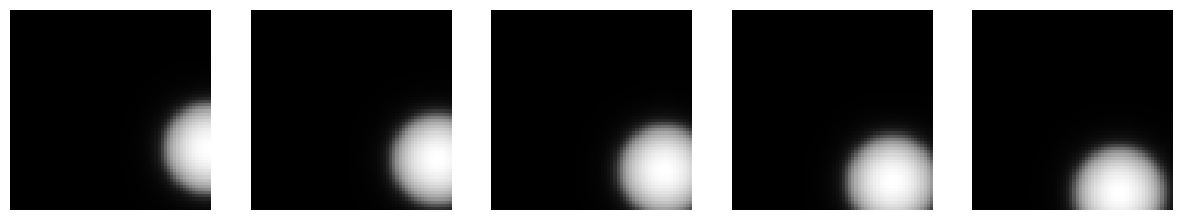

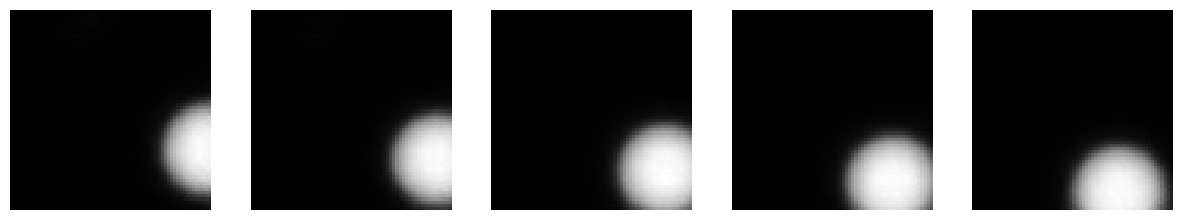

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seq_len = 256
input_dim = 512
num_heads = 16
d_k = 64
d_v = 128

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Initialize the autoencoder, loss function and optimizer
autoencoder = CombinedNetwork(seq_len, input_dim, num_heads, d_k, d_v).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)

# Function to save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Training function
def train_autoencoder(model, train_loader, val_loader, criterion, optimizer, epochs):
    model.train()
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images in val_loader:
                images = images.to(device)
                outputs = model(images)
                loss = criterion(outputs, images)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Save the best model based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_model(model.encoder, 'best_encoder_2.pth')
            save_model(model.decoder, 'best_decoder_2.pth')

    # Print the best validation loss
    print(f'Best Validation Loss: {best_val_loss:.4f}')
    
    return model

# Evaluation function
def evaluate_autoencoder(model, dataloader):
    model.eval()
    original_images = []
    reconstructed_images = []
    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            outputs = model(images)
            original_images.extend(images.cpu())
            reconstructed_images.extend(outputs.cpu())
            break  # Remove this line if you want to evaluate the whole dataset
    return original_images, reconstructed_images

# Assume train_loader, val_loader, and test_loader are defined and loaded elsewhere

# Train the autoencoder
autoencoder = train_autoencoder(autoencoder, train_loader, val_loader, criterion, optimizer, epochs=1000)

# Evaluate the autoencoder
original_images, reconstructed_images = evaluate_autoencoder(autoencoder, test_loader)

# Display original and reconstructed images
show_images([original_images[i] for i in range(5)], nrow=1, ncol=5)
show_images([reconstructed_images[i] for i in range(5)], nrow=1, ncol=5)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np

# 定义一个简单的时间序列数据集
class VideoDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        return (self.data[idx:idx+self.seq_length], self.data[idx+self.seq_length])

# 定义一个简单的Transformer Encoder模型
class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, output_dim):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, src):
        src = self.embedding(src)
        src = src.permute(1, 0, 2)  # Transformer expects sequence length first
        transformer_output = self.transformer(src)
        output = self.fc(transformer_output[-1])
        return output

# 创建一个简单的视频数据集（假设每帧是一个向量表示）
num_samples = 1000
frame_dim = 64
seq_length = 10
data = np.random.randn(num_samples, frame_dim).astype(np.float32)

# 创建数据集和数据加载器
dataset = VideoDataset(data, seq_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)  # 重要的是 shuffle=False

# 模型参数
input_dim = frame_dim
embed_dim = 128
num_heads = 4
num_layers = 2
output_dim = frame_dim

# 初始化模型、损失函数和优化器
model = TransformerModel(input_dim, embed_dim, num_heads, num_layers, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 20
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 简单的预测
test_input = torch.tensor(data[:seq_length]).unsqueeze(0)  # 单个测试序列
with torch.no_grad():
    predicted_frame = model(test_input)
print(f'Predicted frame: {predicted_frame}')

Epoch [1/20], Loss: 1.0339
Epoch [2/20], Loss: 1.0043
Epoch [3/20], Loss: 1.0046
Epoch [4/20], Loss: 0.9756
Epoch [5/20], Loss: 0.9290
Epoch [6/20], Loss: 0.8321
Epoch [7/20], Loss: 0.7237
Epoch [8/20], Loss: 0.6651
Epoch [9/20], Loss: 0.5912
Epoch [10/20], Loss: 0.5145
Epoch [11/20], Loss: 0.4510
Epoch [12/20], Loss: 0.4218
Epoch [13/20], Loss: 0.3553
Epoch [14/20], Loss: 0.3169
Epoch [15/20], Loss: 0.2912
Epoch [16/20], Loss: 0.2557
Epoch [17/20], Loss: 0.2384
Epoch [18/20], Loss: 0.2186
Epoch [19/20], Loss: 0.1920
Epoch [20/20], Loss: 0.2026
Predicted frame: tensor([[ 0.2588,  0.2486,  0.3501,  0.1492, -0.0381,  0.3202,  0.2120,  1.4427,
         -1.0491, -0.3969,  0.7886, -1.0643,  0.1508,  0.4327,  0.2614,  0.3050,
          1.4785,  0.2741, -0.9014,  0.8219,  0.3496, -1.6476,  1.4352,  0.3681,
         -0.0487,  0.4583,  0.3562, -0.3464, -0.5318,  0.2123,  0.0624,  0.2190,
          0.2694,  0.1617,  0.5179,  0.4126,  0.1255,  1.4240,  0.6631, -0.7760,
         -0.6350, -1.6177, 

First images:


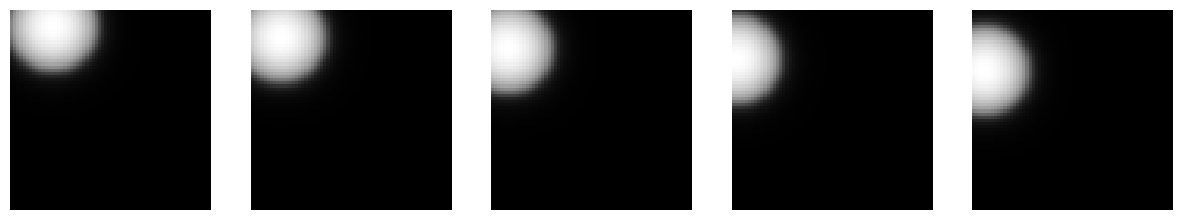

Next images:


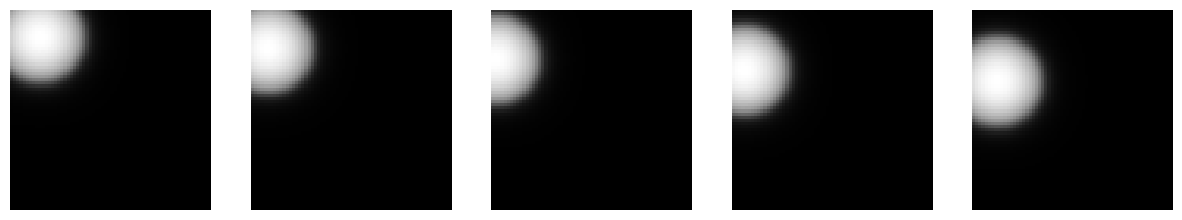

torch.Size([64, 1, 64, 64]) torch.Size([64, 1, 64, 64])


In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')], key=lambda x: int(x.split('_')[1].split('.')[0]))
        self.transform = transform

    def __len__(self):
        return len(self.image_files) - 1  # Subtract 1 because the last image has no next image

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        next_img_name = os.path.join(self.image_dir, self.image_files[idx + 1])
        
        image = Image.open(img_name).convert('L')  # Convert image to grayscale
        next_image = Image.open(next_img_name).convert('L')  # Convert next image to grayscale
        
        if self.transform:
            image = self.transform(image)
            next_image = self.transform(next_image)
        
        return image, next_image

# Define the directory where images are stored
image_dir = 'images'

# Define transformations (if any)
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the dataset
dataset = CustomDataset(image_dir=image_dir, transform=transform)

# Calculate lengths for train, val, test datasets
total_len = len(dataset)
train_len = int(0.6 * total_len)
val_len = int(0.2 * total_len)
test_len = total_len - train_len - val_len

# Create subsets manually by indices
train_indices = list(range(0, train_len))
val_indices = list(range(train_len, train_len + val_len))
test_indices = list(range(train_len + val_len, total_len))

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Function to display images
def show_images(images, nrow=1, ncol=5):
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 3))
    for i in range(ncol):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

# Display the first five pairs of images in the dataset
if __name__ == '__main__':
    # Display the first five pairs of images
    first_five_pairs = [dataset[i] for i in range(5)]
    first_images = [pair[0] for pair in first_five_pairs]
    next_images = [pair[1] for pair in first_five_pairs]
    
    print("First images:")
    show_images(first_images)
    
    print("Next images:")
    show_images(next_images)
    
    # Example usage of data loaders
    for images, targets in train_loader:
        print(images.size(), targets.size())  # Example output: torch.Size([64, 1, H, W]) torch.Size([64, 1, H, W])
        break